In [24]:
import numpy as np
from scipy import interpolate
import time
import logging
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
infreq = 1000.0
outfreq = 100000.0

In [30]:
freq = 1.5
cycles = 20
dur = cycles/freq

In [36]:
tin = np.arange(0,dur, 1/infreq) - 1.0
pos = 15.0 * np.sin(2*np.pi*freq*tin)
vel = 15.0 * 2*np.pi * freq * np.cos(2*np.pi*freq*tin)

pos[tin < 0] = 0
vel[tin < 0] = 0

In [32]:
stepsperrev = 6400.0

In [45]:
tout = np.arange(tin[0], tin[-1], 1/outfreq)

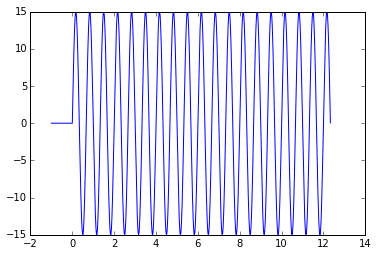

In [46]:
plt.plot(tin, pos)
plt.show()

In [58]:
def make_motor_stepper_pulses(t, pos, vel, tout, outsampfreq, stepsperrev):
    poshi = interpolate.interp1d(t, pos, kind='linear', assume_sorted=True, bounds_error=False,
                                 fill_value=0.0)(tout)
    velhi = interpolate.interp1d(t, vel, kind='linear', assume_sorted=True, bounds_error=False,
                                 fill_value=0.0)(tout)

    stepsize = 360.0 / stepsperrev
    maxspeed = stepsize * outsampfreq / 2

    if np.any(np.abs(vel) > maxspeed):
        raise ValueError('Motion is too fast!')

    starttime = time.time()
    stepnum = np.floor(poshi/stepsize)
    dstep = np.diff(stepnum)
    motorstep2 = np.concatenate((np.array([0], dtype='uint8'), (dstep != 0).astype('uint8')))
    motordirection2 = (velhi <= 0).astype('uint8')
    elapsed = time.time() - starttime
    print 'stepper0 elapsed: %f' % elapsed
    
    starttime = time.time()

    motorstep = np.zeros_like(tout, dtype=np.uint8)
    motordirection = np.zeros_like(tout, dtype=np.uint8)
    curpos = pos[0]
    for i, cmdpos in enumerate(poshi[2:], start=1):
        motordirection[i] = motordirection[i-1]
        if motorstep[i-1] == 1:
            # can't step twice in a row
            continue
        elif cmdpos - curpos >= stepsize:
            motorstep[i] = 1
            motordirection[i] = 0
            curpos += stepsize
        elif cmdpos - curpos <= -stepsize:
            motorstep[i] = 1
            motordirection[i] = 1
            curpos -= stepsize

    elapsed = time.time() - starttime
    print 'stepper elapsed: %f' % elapsed

    motorenable = np.ones_like(motordirection)
    motorenable[-5:] = 0

    return motorstep, motordirection, motorstep2, motordirection2

In [59]:
step, direc, step2, direc2 = make_motor_stepper_pulses(tin, pos, vel, tout, outfreq, stepsperrev)

stepper0 elapsed: 0.021000
stepper elapsed: 3.709000

In [48]:
step.shape

(1333300L,)

In [51]:
[step[100000:100100], step2[100000:100100]]

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)]

In [57]:
np.sum(step[0:-1] != step2[1:])

37